# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../cmds/')
# import TA_utils as ta

sns.set_theme()

In [5]:
FILEIN = '../data/midterm_1_data.xlsx'
sheet_exrets = 'stocks excess returns'
sheet_proshares = 'proshares excess returns'
sheet_fxrets = 'fx carry returns'

retsx = pd.read_excel(FILEIN, sheet_name=sheet_exrets).set_index('date')
proshares = pd.read_excel(FILEIN, sheet_name=sheet_proshares).set_index('date')
fxrets = pd.read_excel(FILEIN, sheet_name=sheet_fxrets).set_index('date')

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

***

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

TIPS is found to have correlation of 0% to IEF and 0% to SPY:

- TIPS would've formed it's own asset class as it would provide best and immense diversification benefits being uncorrelated to both treasury bonds and S&P equity stocks.

TIPS is found to have correlation of 100% to IEF:

- In this case TIPS would've not provided any additional diversification benefits compared to treasury bonds thus making it pretty useless standalone. It should then be made a part of the IEF asset class for the 2-step optimisation problem.

I don't think TIPS could have 0% correlation to every other asset since :

TIPS have a priori a similar default risk to public bonds and adding TIPS mostly impacts the allocation in domestic bonds, therefore making them more similar than different.

### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?

Intercept is needed when adjusting the level of returns, otherwise no-intercept replication is enough to track the volatility.

Including an intercept increases our correlation marginally.
The intercept ensures we are matching the variation in the factors, where we would like to match the overall level.

***

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [75]:
def tangency_weights(returns, cov_mat=None):
    # Calculate the inverse of the covariance matrix
    if cov_mat is None:
        cov_inv = np.linalg.inv(returns.cov() * 12)  # Annualized covariance matrix
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag(cov))  # Diagonal matrix from covariance
        covmat_adjusted = cov_mat * cov + (1 - cov_mat) * covmat_diag  # Weighted cov matrix
        cov_inv = np.linalg.inv(covmat_adjusted * 12)  # Annualized

    # Construct ones vector for assets
    ones = np.ones(len(returns.columns))

    # Calculate the mean returns vector
    mu = returns.mean() * 12  # Annualized mean returns

    # Calculate scaling factor for tangency weights
    scaling = 1 / (ones @ cov_inv @ mu)

    # Calculate tangency weights
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(
        index=returns.columns, data=tangent_return, columns=['Tangent Weights']
    )

    return tangency_wts

In [76]:
retsx_IS = retsx.loc[:'2018']
# print(retsx_IS)
wts = pd.DataFrame(index = retsx_IS.columns, columns = ['tangency','regularized'])
sum_abs_wts = pd.DataFrame(columns = ['tangency','regularized'])
wts.loc[:,'tangency'] = tangency_weights(retsx_IS.reset_index(drop=True), cov_mat=1)
wts.loc[:,'regularized'] = tangency_weights(retsx_IS.reset_index(drop=True), cov_mat = (1/2)).values

sum_abs_wts.loc['abs sum wts'] = abs(wts.loc[:,:]).sum()

print(wts)
print(sum_abs_wts)

       tangency regularized
AAPL  -0.127836   -0.014706
AMZN  -0.040576     0.03631
BRK-B  0.131333    0.109162
GOOGL  0.025968    0.050545
JNJ    0.130408     0.09919
JPM   -0.013929    0.053691
LLY    0.352670    0.214949
META   0.030541    0.034896
MSFT   0.137917     0.08997
NVDA   0.163501    0.071696
TSLA   0.030066    0.036511
UNH    0.290230    0.189845
V      0.306209    0.184558
XOM   -0.416502   -0.156617
             tangency regularized
abs sum wts  2.197687    1.342647


### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [77]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [78]:
mean_returns = retsx_IS.mean()
wts_scaled = wts_scaled.reindex(mean_returns.index)

scaling_factor = mean_returns @ wts_scaled

wts_scaled *= scaling_factor

wts_scaled /= wts_scaled.sum()

wts_scaled

performance_summary(retsx_IS @ wts_scaled, 12)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
tangency,0.338374,0.145741,2.321755,-0.568704,0.164276,-0.066267,-0.068724,-0.071256,0.125616,-0.099993,2018-08-31,2018-12-31,NaT
regularized,0.266917,0.115811,2.304755,-0.563746,0.357772,-0.03467,-0.056653,-0.083753,0.088254,-0.112384,2018-08-31,2018-12-31,NaT


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [79]:
retsx_OOS = retsx.loc['2019':]
ret_OOS = retsx_OOS @ wts_scaled
ret_OOS[-3:]

,tangency,regularized
date,,
2024-07-31,-0.03618,-0.011065
2024-08-31,0.092214,0.06006
2024-09-30,-0.024651,-0.015087


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [80]:
performance_summary(ret_OOS, 12)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
tangency,0.423313,0.215142,1.967601,-0.390733,-0.156227,-0.072874,-0.095423,-0.140048,0.165675,-0.222902,2021-12-31,2022-09-30,2023-03-31
regularized,0.318651,0.182131,1.74957,-0.289743,-0.566991,-0.065452,-0.075477,-0.081948,0.141332,-0.19058,2021-12-31,2022-09-30,2023-04-30


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

The tangency portfolio performed better out-of-sample in terms of better risk-adjusted return, as its higher Sharpe ratio indicates superior returns for the level of risk taken. The regularized portfolio is less volatile and thus more stable, but it delivers lower returns and a lower Sharpe ratio.

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [81]:
def calc_multivariate_regression(y, X, intercept=True, adj=12):
    """
    Calculate a multivariate regression of y on X. Adds useful metrics such
    as the Information Ratio and Tracking Error. Note that we can't calculate
    Treynor Ratio or Downside Beta here.

    Args:
        y : target variable
        X : independent variables
        intercept (bool, optional): Defaults to True.
        adj (int, optional): Annualization factor. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    if intercept:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()
    summary = dict()

    inter = results.params.iloc[0] if intercept else 0
    betas = results.params.iloc[1:] if intercept else results.params

    summary["Alpha"] = inter * adj
    summary["R-Squared"] = results.rsquared

    X_cols = X.columns[1:] if intercept else X.columns

    for i, col in enumerate(X_cols):
        summary[f"{col} Beta"] = betas[i]

    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = results.resid.std() * np.sqrt(adj)
    
    if isinstance(y, pd.Series):
        return pd.DataFrame(summary, index=[y.name])
    else:
        return pd.DataFrame(summary, index=y.columns)



In [82]:
regr = calc_multivariate_regression(proshares['HDG US Equity'], proshares[['QAI US Equity', 'SPY US Equity', 'EEM US Equity', 'UPRO US Equity', 'SPXU US Equity', 'IWM US Equity', 'EFA US Equity']], intercept=True, adj=52)

betas = regr.loc[:, regr.columns.str.contains('Beta')].T

exposure = betas * -1_000_000
exposure.index = exposure.index.str.replace('Beta', '')
exposure.loc['Total'] = exposure.sum()
exposure.style.format('${:,.0f}')

,HDG US Equity
QAI US Equity,"$-151,537"
SPY US Equity,"$-515,376"
EEM US Equity,"$-44,816"
UPRO US Equity,"$140,222"
SPXU US Equity,"$-32,654"
IWM US Equity,"$-139,036"
EFA US Equity,"$-117,000"
Total,"$-860,198"


### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

In [83]:
abs(exposure).sum()


HDG US Equity    2.000841e+06
dtype: float64

In [84]:
regr[['R-Squared']].T

,HDG US Equity
R-Squared,0.912884


Higher R-squared values (close to 1) indicate that the hedge is effective in explaining the variance in the portfolio returns, suggesting the hedge is well-constructed.

A high gross notional value indicates that the hedge requires large exposure.

### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

In [85]:
def stats_OLS(model, y, x):
    output = model.params.to_frame(name=y.name)  
    return output

y = proshares['HDG US Equity']
x = sm.add_constant(proshares.drop(columns='HDG US Equity')) 

replication_model = sm.OLS(y, x).fit()

replication_stats = stats_OLS(replication_model, y, x).round(3)
replication_stats

,HDG US Equity
const,-0.001
QAI US Equity,0.165
SPY US Equity,0.508
EEM US Equity,0.056
EFA US Equity,0.140
EUO US Equity,0.035
IWM US Equity,0.133
SPXU US Equity,0.027
UPRO US Equity,-0.148


In [86]:
betas = replication_model.params.drop('const')

basket_portfolio = (proshares[betas.index] * betas).sum(axis=1)

final_three_values = basket_portfolio.tail(3)
final_three_values


date
2024-07-31    0.021925
2024-08-31    0.005437
2024-09-30    0.008961
dtype: float64

### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

In [87]:
###prompt: fix my code: 

# y_pred = replication_model.predct(sm.add_constant(proshares.drop('HDG US Equity', axis=1)))
# epsilon_t = proshares['HDG US Equity'] - y_pred

# strategy_returns = pd.Series(index=proshares.index)

# for t in range(len(epsilon_t)):  
#     if epsilon_t.iloc[t] < 0:  
#         strategy_returns.iloc[t] = 2 * proshares['HDG US Equity'].iloc[t + 1] - basket_portfolio.iloc[t]  
#     else:
#         strategy_returns.iloc[t] = 2 * basket_portfolio.iloc[t + 1] - proshares['HDG US Equity'].iloc[t]  

# mean_return = strategy_returns.mean() * 250  
# volatility = strategy_returns.std() * np.sqrt(250)  
# sharpe_ratio = mean_return / volitility  

# print(f"Annualized Mean Return: {mean_ret}") 
# print(f"Annualized Volatility: {volatility}")
# print(f"Sharpe Ratio: {sharpe_ratio}")


In [88]:
y_pred = replication_model.predict(sm.add_constant(proshares.drop(columns='HDG US Equity')))
epsilon_t = proshares['HDG US Equity'] - y_pred

strategy_returns = pd.Series(index=proshares.index)

for t in range(len(epsilon_t) - 1):  # Ensure no out-of-bounds on t+1
    if epsilon_t.iloc[t] <= 0:
        strategy_returns.iloc[t + 1] = 2 * proshares['HDG US Equity'].iloc[t + 1] - basket_portfolio.iloc[t + 1]
    else:
        strategy_returns.iloc[t + 1] = 2 * basket_portfolio.iloc[t + 1] - proshares['HDG US Equity'].iloc[t + 1]

mean_return = strategy_returns.mean() * 252  # Annualize the mean
volatility = strategy_returns.std() * np.sqrt(252)  # Annualize the volatility
sharpe_ratio = mean_return / volatility  # Calculate the Sharpe Ratio

print(f"Annualized Mean Return: {mean_return}")
print(f"Annualized Volatility: {volatility}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Annualized Mean Return: 0.9710878174513432
Annualized Volatility: 0.27557639565084663
Sharpe Ratio: 3.5238425089270153


### 5.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

In [95]:
y = proshares['QAI US Equity'] 
X = sm.add_constant(proshares.drop(columns=['QAI US Equity'])) 

model = sm.OLS(y, X).fit()

betas = model.params.drop('const')  
beta_sum_abs = betas.abs().sum()

alpha = model.params['const']

residuals = y - model.predict(X)
tracking_error = residuals.std()
information_ratio = alpha / tracking_error

r_squared = model.rsquared

correlation_matrix = proshares.drop(columns=['QAI US Equity']).corr()

print(f"Betas:\n{betas}\n")
print(f"Sum of Absolute Betas: {beta_sum_abs:.4f}")
print(f"Alpha (Intercept): {alpha:.4f}")
print(f"Information Ratio: {information_ratio:.4f}")
print(f"R-squared: {r_squared:.4f}")
print("\nCorrelation Matrix:")
print(correlation_matrix)

Betas:
HDG US Equity     0.231451
SPY US Equity     0.565072
EEM US Equity     0.047792
EFA US Equity     0.032642
EUO US Equity    -0.020484
IWM US Equity    -0.000157
SPXU US Equity    0.051074
UPRO US Equity   -0.095099
dtype: float64

Sum of Absolute Betas: 1.0438
Alpha (Intercept): -0.0005
Information Ratio: -0.0914
R-squared: 0.8420

Correlation Matrix:
                HDG US Equity  SPY US Equity  EEM US Equity  EFA US Equity  \
HDG US Equity        1.000000       0.873618       0.801281       0.894867   
SPY US Equity        0.873618       1.000000       0.708186       0.865371   
EEM US Equity        0.801281       0.708186       1.000000       0.833854   
EFA US Equity        0.894867       0.865371       0.833854       1.000000   
EUO US Equity       -0.419163      -0.381608      -0.601403      -0.575282   
IWM US Equity        0.894708       0.867994       0.661675       0.784217   
SPXU US Equity      -0.814764      -0.955545      -0.656500      -0.812151   
UPRO US Equity

### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [89]:
fxrets = pd.read_excel(FILEIN, sheet_name=sheet_fxrets).set_index('date')

jpy_returns = fxrets[['JPY']]

jpy_var_1pct = jpy_returns.expanding().quantile(0.01)

final_var_1pct = jpy_var_1pct.iloc[-1].values[0]

final_var_1pct


-0.01717837630807654

### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [90]:
jpy_returns = fxrets[['JPY']]

rolling_vol_jpy = jpy_returns['JPY'].rolling(window=233).std().shift(1)

var_jpy = -2.33 * rolling_vol_jpy.dropna()

final_var_jpy = var_jpy.tail(3)

print(final_var_jpy)

date
2024-08-01   -0.013345
2024-08-02   -0.013358
2024-08-05   -0.013646
Name: JPY, dtype: float64


### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [91]:
def calc_ewma_volatility(
    excess_returns: pd.Series, 
    theta: float = 0.94, 
    initial_vol: float = 0.2 / np.sqrt(252)
) -> pd.Series:
    var_t0 = initial_vol ** 2
    ewma_var = [var_t0]  

    for ret in excess_returns:
        new_ewma_var = ewma_var[-1] * theta + (ret ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)

    ewma_vol = np.sqrt(ewma_var[1:])

    return pd.Series(ewma_vol, index=excess_returns.index)

ewma_vol_jpy = calc_ewma_volatility(jpy_returns['JPY'].shift().dropna())

ewma_vol_jpy.tail(3)


date
2024-08-01    0.007650
2024-08-02    0.007481
2024-08-05    0.008644
dtype: float64

### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

In [92]:
# prompt: give me code to plot my volatities

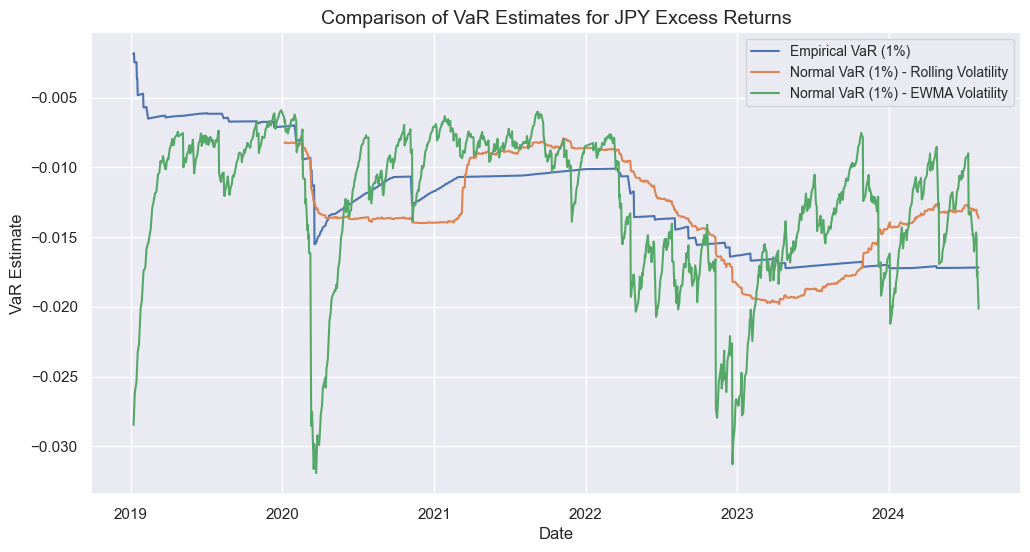

In [93]:
import matplotlib.pyplot as plt

# Calculate the three VaR series
# 1. Empirical VaR (1%)
jpy_var_empirical = jpy_var_1pct

var_normal_rolling = var_jpy

# 3. EWMA-based Normal VaR (with λ = 0.94)
ewma_vol_jpy = ewma_vol_jpy
var_ewma = -2.33 * ewma_vol_jpy

# Align the indices for plotting
var_normal_rolling = var_normal_rolling.reindex(jpy_var_empirical.index, method='ffill')
var_ewma = var_ewma.reindex(jpy_var_empirical.index, method='ffill')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(jpy_var_empirical, label='Empirical VaR (1%)', linewidth=1.5)
plt.plot(var_normal_rolling, label='Normal VaR (1%) - Rolling Volatility', linewidth=1.5)
plt.plot(var_ewma, label='Normal VaR (1%) - EWMA Volatility', linewidth=1.5)

# Formatting the plot
plt.title('Comparison of VaR Estimates for JPY Excess Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('VaR Estimate', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)

# Display the plot
plt.show()


#### Empirical VaR (1%):
- *Pros:* Reflects real data distribution, including skewness and fat tails.
- *Cons:* Backward-looking and sensitive to outliers.

#### Rolling Volatility:
- *Pros:* Smooth and stable with simple computation.
- *Cons:* Assumes normality, underestimates extreme risks, and reacts slowly to changes.

#### EWMA Volatility:
- *Pros:* Reacts to recent market changes, suitable for dynamic environments.
- *Cons:* λ selection impacts sensitivity, and normality assumption can underestimate risks.


### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

hit rate is a good statistic for this

In [94]:
def calculate_hit_rate(returns, var_series):
    returns_aligned, var_aligned = returns.align(var_series, join='inner')
    exceptions = (returns < var_series).sum()
    total_obs = len(returns)
    return exceptions / total_obs

aligned_returns = jpy_returns['JPY'].dropna()

hit_rate_empirical = calculate_hit_rate(aligned_returns, jpy_var_empirical.squeeze())
hit_rate_normal_rolling = calculate_hit_rate(aligned_returns, var_normal_rolling.squeeze())
hit_rate_ewma = calculate_hit_rate(aligned_returns, var_ewma.squeeze())

print(f"Empirical VaR hit rate: {hit_rate_empirical}")
print(f"rolling volatility hit rate: {hit_rate_normal_rolling}")
print(f"ewma volatility hit rate: {hit_rate_ewma}")


Empirical VaR hit rate: 0.022988505747126436
rolling volatility hit rate: 0.020689655172413793
ewma volatility hit rate: 0.01992337164750958


ewma performs the best as the hit rate is closest to 1%

***